<a href="https://colab.research.google.com/github/Rapurva/Financial-Trials/blob/master/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from functools import reduce

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
 
plt.style.use('seaborn-deep')
pd.options.display.float_format = "{:,.2f}".format

In [30]:
import pandas_datareader as web
stock = 'AUROPHARMA.NS'
stdate = '2019-01-01'
endate = '2020-01-08'
#Get the Stock Quote: The price of a stock as quoted on an exchange
df = web.DataReader(stock, data_source='yahoo', start=stdate, end=endate) #end = '2017-12-31', format = 'YYYY-MM-DD'
#Show the data
df.reset_index(level=0, inplace=True)
df


,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-01-01,737.50,729.60,734.00,733.15,"1,340,165.00",729.87
1,2019-01-02,732.40,719.00,729.00,724.35,"1,845,752.00",721.11
2,2019-01-03,723.40,710.55,721.00,715.90,"1,357,059.00",712.70
3,2019-01-04,728.00,708.25,714.00,725.85,"1,340,101.00",722.60
4,2019-01-07,731.00,719.60,726.00,724.75,"1,413,246.00",721.51
...,...,...,...,...,...,...,...
244,2020-01-03,471.90,457.20,461.00,460.30,"2,784,762.00",460.30
245,2020-01-06,458.95,442.00,458.40,443.50,"2,195,956.00",443.50
246,2020-01-07,454.95,446.50,446.50,452.40,"1,731,056.00",452.40
247,2020-01-08,453.85,445.40,445.40,451.35,"1,147,686.00",451.35


In [31]:
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 0 to 248
Data columns (total 7 columns):
ds                  249 non-null datetime64[ns]
y                   249 non-null float64
dayname             249 non-null object
month               249 non-null int64
year                249 non-null int64
month/year          249 non-null object
month/year_index    249 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 15.6+ KB


In [32]:
stock_price = df[['Date','Adj Close']]
stock_price.columns = ['ds', 'y']
stock_price.head(10)

,ds,y
0,2019-01-01,729.87
1,2019-01-02,721.11
2,2019-01-03,712.70
3,2019-01-04,722.60
4,2019-01-07,721.51
5,2019-01-08,743.21
6,2019-01-09,753.86
7,2019-01-10,773.47
8,2019-01-11,766.40
9,2019-01-14,766.75


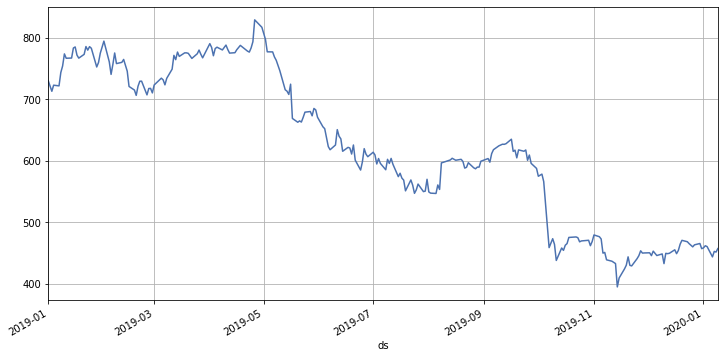

In [33]:
stock_price.set_index('ds').y.plot(figsize=(12,6), grid=True);

In [34]:
model = Prophet()
model.fit(stock_price)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
future = model.make_future_dataframe(1095, freq='d')

future_boolean = future['ds'].map(lambda x : True if x.weekday() in range(0, 5) else False)
future = future[future_boolean] 

future.tail()

,ds
1337,2023-01-02
1338,2023-01-03
1339,2023-01-04
1340,2023-01-05
1341,2023-01-06


In [36]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1025,2023-01-02,-704.21,"-2,296.52",953.81,"-2,300.22",965.26,2.25,2.25,2.25,2.25,2.25,2.25,0.00,0.00,0.00,-701.97
1026,2023-01-03,-705.24,"-2,287.15",974.45,"-2,302.69",966.97,5.91,5.91,5.91,5.91,5.91,5.91,0.00,0.00,0.00,-699.33
1027,2023-01-04,-706.27,"-2,289.62",964.84,"-2,305.16",968.67,2.72,2.72,2.72,2.72,2.72,2.72,0.00,0.00,0.00,-703.55
1028,2023-01-05,-707.30,"-2,310.79",953.69,"-2,307.63",970.37,6.41,6.41,6.41,6.41,6.41,6.41,0.00,0.00,0.00,-700.89
1029,2023-01-06,-708.33,"-2,295.20",983.71,"-2,310.11",972.08,3.64,3.64,3.64,3.64,3.64,3.64,0.00,0.00,0.00,-704.69


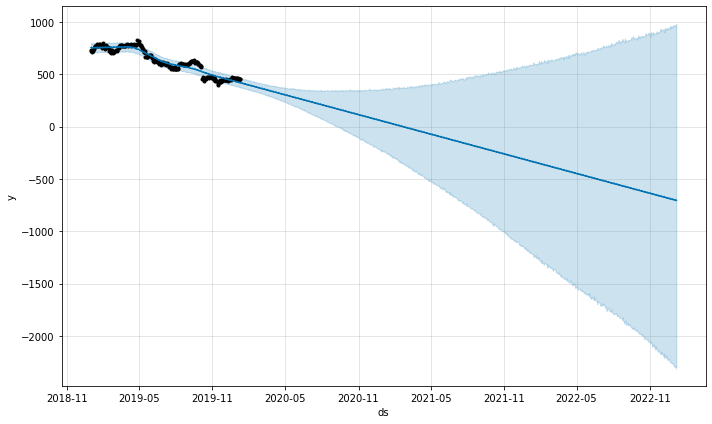

In [37]:
model.plot(forecast);

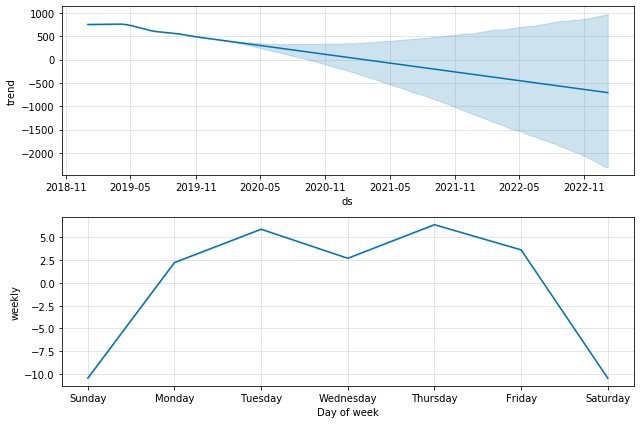

In [38]:
model.plot_components(forecast);

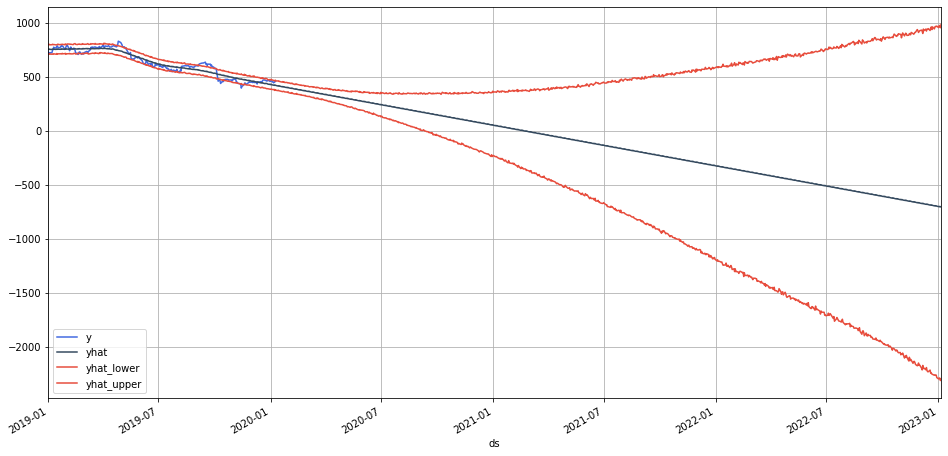

In [39]:
stock_price_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df = pd.merge(stock_price, stock_price_forecast, on='ds', how='right')
df.set_index('ds').plot(figsize=(16,8), color=['royalblue', "#34495e", "#e74c3c", "#e74c3c"], grid=True);

In [0]:
# Backtesting
stock_price['dayname'] = stock_price['ds'].dt.day_name()
stock_price['month'] = stock_price['ds'].dt.month
stock_price['year'] = stock_price['ds'].dt.year
stock_price['month/year'] = stock_price['month'].map(str) + '/' + stock_price['year'].map(str) 

stock_price = pd.merge(stock_price, 
                       stock_price['month/year'].drop_duplicates().reset_index(drop=True).reset_index(),
                       on='month/year',
                       how='left')

stock_price = stock_price.rename(columns={'index':'month/year_index'})

In [41]:
loop_list = stock_price['month/year'].unique().tolist()
max_num = len(loop_list) - 1
forecast_frames = []

for num, item in enumerate(loop_list):

    if  num == max_num:
        pass
    else:
        df = stock_price.set_index('ds')[
             stock_price[stock_price['month/year'] == loop_list[0]]['ds'].min():\
             stock_price[stock_price['month/year'] == item]['ds'].max()]
        
        df = df.reset_index()[['ds', 'y']]
        
        model = Prophet()
        model.fit(df)
        
        future = stock_price[stock_price['month/year_index'] == (num + 1)][['ds']]

        forecast = model.predict(future)
        forecast_frames.append(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 17.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override th

In [0]:
stock_price_forecast = reduce(lambda top, bottom: pd.concat([top, bottom], sort=False), forecast_frames)
stock_price_forecast = stock_price_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
stock_price_forecast.to_csv('stock_price_forecast.csv', index=False)

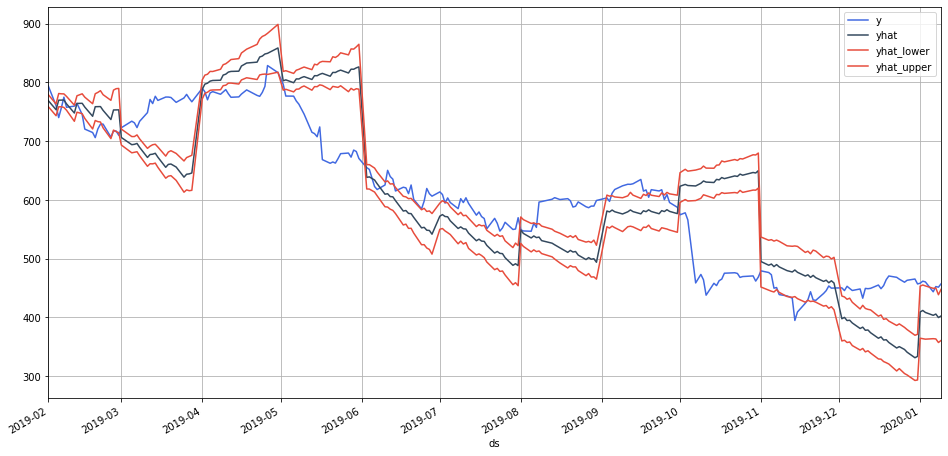

In [43]:
stock_price_forecast = pd.read_csv('stock_price_forecast.csv', parse_dates=['ds'])
df = pd.merge(stock_price[['ds','y', 'month/year_index']], stock_price_forecast, on='ds')
df['Percent Change'] = df['y'].pct_change()
df.set_index('ds')[['y', 'yhat', 'yhat_lower', 'yhat_upper']].plot(figsize=(16,8), color=['royalblue', "#34495e", "#e74c3c", "#e74c3c"], grid=True)

In [0]:
df['Hold'] = (df['Percent Change'] + 1).cumprod()
df['Prophet'] = ((df['yhat'].shift(-1) > df['yhat']).shift(1) * (df['Percent Change']) + 1).cumprod()
df['Prophet Thresh']  = ((df['y'] > df['yhat_lower']).shift(1)* (df['Percent Change']) + 1).cumprod()
df['Seasonality'] = ((~df['ds'].dt.month.isin([8,9])).shift(1) * (df['Percent Change']) + 1).cumprod()

Hold = 575
Prophet = 973
Prophet Thresh = 756
Seasonality = 550


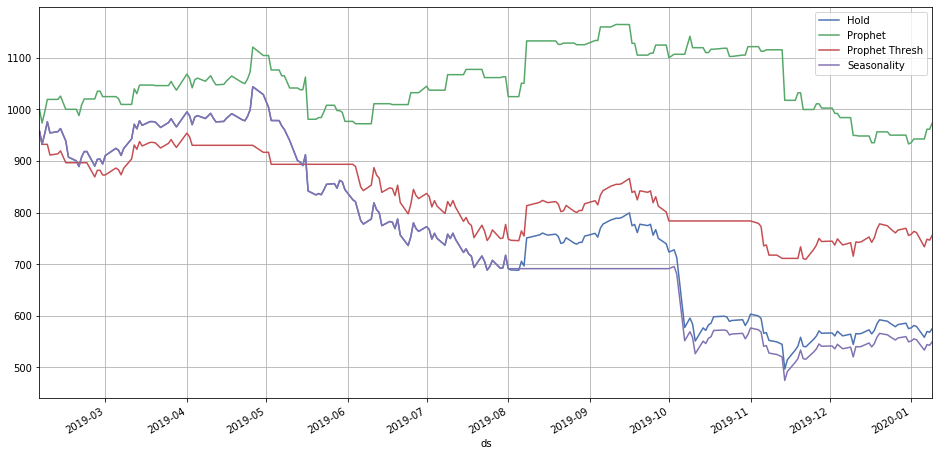

In [45]:
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh','Seasonality']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")

'Best Yhat = 0.90'

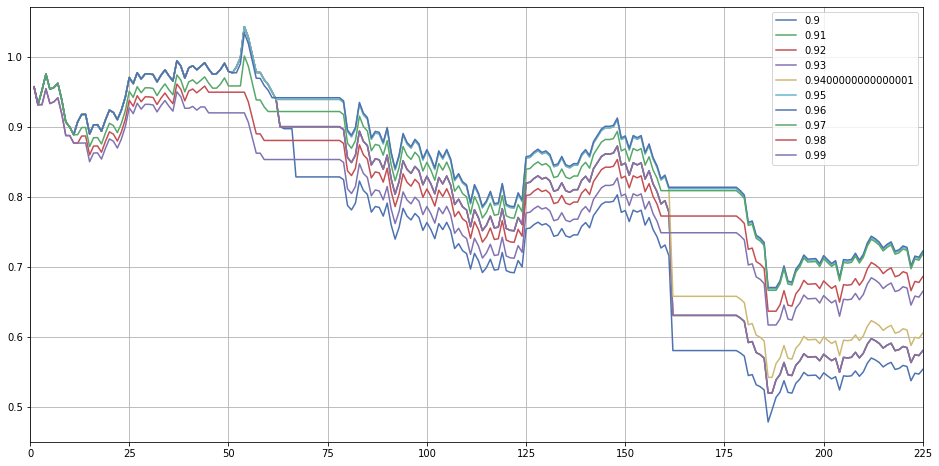

In [46]:
performance = {}

for x in np.linspace(.9,.99,10):
    y = ((df['y'] > df['yhat_lower']*x).shift(1)* (df['Percent Change']) + 1).cumprod()
    performance[x] = y
    
best_yhat = pd.DataFrame(performance).max().idxmax()
pd.DataFrame(performance).plot(figsize=(16,8), grid=True);
f'Best Yhat = {best_yhat:,.2f}'

In [0]:
df['Optimized Prophet Thresh']  = ((df['y'] > df['yhat_lower'] * best_yhat).shift(1) * 
                                   (df['Percent Change']) + 1).cumprod()
                                   

Hold = 575
Prophet = 973
Prophet Thresh = 756
Seasonality = 550
Optimized Prophet Thresh = 553


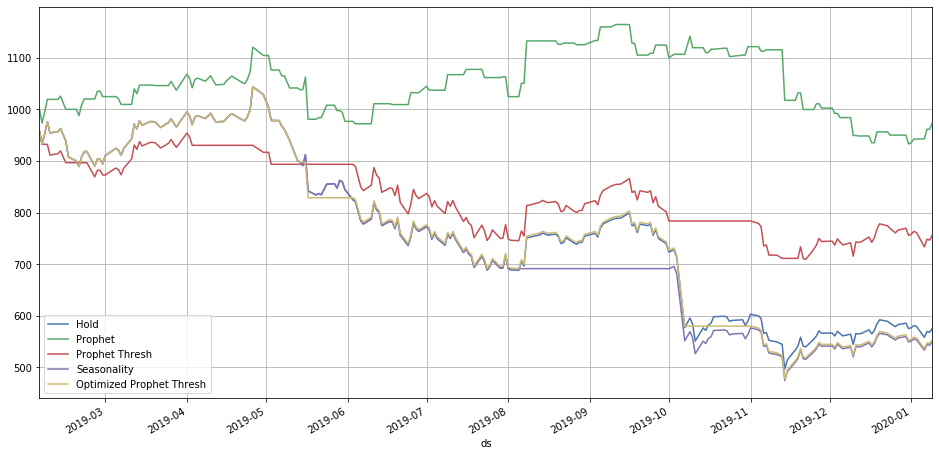

In [48]:
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh',
                              'Seasonality', 'Optimized Prophet Thresh']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")
print(f"Optimized Prophet Thresh = {df['Optimized Prophet Thresh'].iloc[-1]*1000:,.0f}")

In [0]:
fcst_thresh = {}

for num, index in enumerate(df['month/year_index'].unique()):

    temp_df = df.set_index('ds')[
         df[df['month/year_index'] == df['month/year_index'].unique()[0]]['ds'].min():\
         df[df['month/year_index'] == index]['ds'].max()]

    performance = {}
    
    for thresh in np.linspace(0, .99, 100):
        percent =  ((temp_df['y'] > temp_df['yhat_lower'] * thresh).shift(1)* (temp_df['Percent Change']) + 1).cumprod()
        performance[thresh] = percent
    
    best_thresh = pd.DataFrame(performance).max().idxmax()
    
    if num == len(df['month/year_index'].unique())-1:
        pass
    else:
        fcst_thresh[df['month/year_index'].unique()[num+1]] = best_thresh

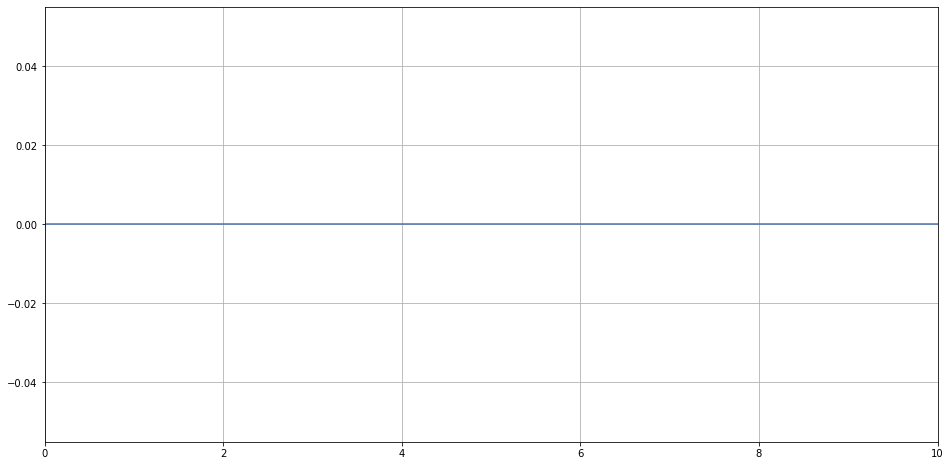

In [50]:
fcst_thresh = pd.DataFrame([fcst_thresh]).T.reset_index().rename(columns={'index':'month/year_index', 0:'Fcst Thresh'})
fcst_thresh['Fcst Thresh'].plot(figsize=(16,8), grid=True);

Hold = 575
Prophet = 973
Prophet Thresh = 756
Prophet Fcst Thresh = 623


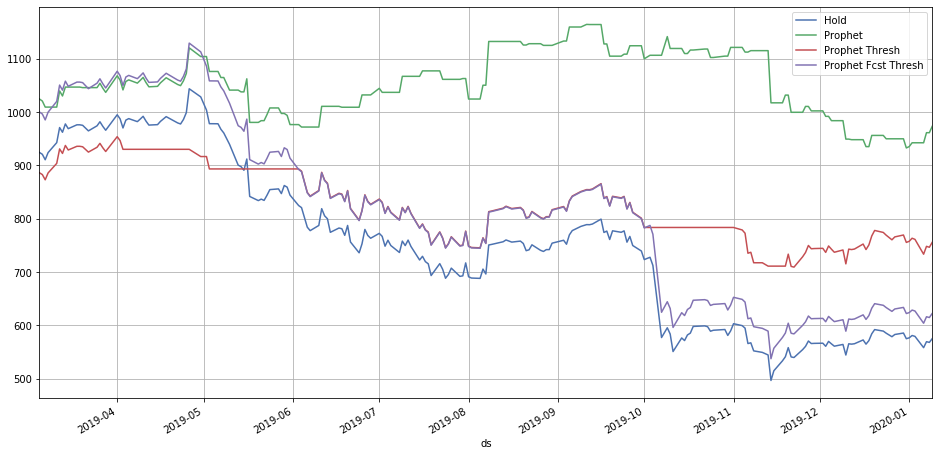

In [51]:
df['yhat_optimized'] = pd.merge(df, fcst_thresh, 
                                on='month/year_index', 
                                how='left')['Fcst Thresh'].shift(1) * df['yhat_lower']
df['Prophet Fcst Thresh']  = ((df['y'] > df['yhat_optimized']).shift(1)* (df['Percent Change']) + 1).cumprod()
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh',
                              'Prophet Fcst Thresh']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
# print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")
print(f"Prophet Fcst Thresh = {df['Prophet Fcst Thresh'].iloc[-1]*1000:,.0f}")